Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [11]:
NAME = "Nate Schaefer"
COLLABORATORS = "Nick Hageman"

---

# Revisting k-NN and Naive Bayes classification

These instructions for installing the widget are **only** if you are using "jupyter lab."  The widet appears to work fine for **VSCode**.

Note: this notebook is best run if you have installed the JupyterLab extension for ipywidgets (anaconda already includes ipywidgets, but the extension to allow the interactivity within Jupyter Lab still needs to be installed). Installing the JupyterLab extension does require that a package called nodejs (not included by default with anaconda).  It can be installed with ananconda, but I have found the anaconda version is not up to date enough to work.

Download and install from:
https://nodejs.org/en

For 2021, version 14.15.5 works.

This installer will attempt to update your path, so you may want to start a new terminal (Mac), or login out/login/reboot in Windows.  See slides for more details.

You can then install the labextension:

jupyter labextension install @jupyter-widgets/jupyterlab-manager

(Instructions for installation from: https://ipywidgets.readthedocs.io/en/latest/user_install.html)

If you do attempt to install, and it does not work, you remove the widget with:

jupyter lab clean

juptery lab build

If you haven't installed the JupyterLab extension for ipywidgets, the code should still work (as anaconda still includes the ipywidgets package), you just will not be able to use the interactive functionality (e.g., use of sliders to change parameter values), which does not affect you ability to complete the assignment.

In [1]:
# imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import pandas as pd
import seaborn as sns
from sklearn import (datasets, metrics,
                     model_selection as skms,
                     naive_bayes, neighbors)
from scipy.stats import norm
import ipywidgets as widgets
from ipywidgets import interact

## Example visualization of a Gaussian (normal) distribution with exam scores
To help provide further intuition on Gaussian (normal) distributions, below we will use an example of plotting a distribution of exam scores from 1000 students using both a histogram and a probability density function (pdf). Note: While we will mostly be using norm.pdf to compute probability density function values, you could also compute the pdf values using an equation. In particular, given mean $\mu$ and standard deviation $\sigma$, the probability density function can be written as:
$\frac{1}{\sigma \sqrt{2\pi}} e^{ \frac{- (x - \mu)^2}{2 \sigma^2}}$

Also see https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html

numpy.random.normal(loc=0.0, scale=1.0, size=None)

In [5]:
@interact #this starts the widget
def exam_grades_example(mean_score = (50,90,5), #widget start, stop, increment ?
                        std = (1,20,1), 
                        plot_pdf = False):
    exam_scores = np.random.normal(mean_score,std,1000)
    display(exam_scores[:20])   #display start thru 20
    print(f'size = {exam_scores.size}')
    
    # To see what is going on, without widgets
    print(f'mean_score = {mean_score}')
    print(f'std = {std}')
    
    # plot_pdf will determine whether we also plot the pdf function
    # plot_pdf = True
    
    # note: density=True makes area sum to one (probabilty density)
    #       From documentation: This is achieved by dividing the count by the number of 
    #       observations times the bin width and not dividing by the total number of 
    #       observations.
    # density=False just returns counts
    density=True
    plt.hist(exam_scores, density=plot_pdf, bins=20, label='histogram') 
    plt.xlabel('exam score');
    plt.xlim((0,100))
    plt.ylabel('counts')
    
    # if desired, plot probability density function in two ways
    if (plot_pdf):
        x=np.linspace(0,100,100)
        # pdf using norm.pdf function
        plt.plot(x, 
                 norm.pdf(x,loc=mean_score,scale=std), 
                 label='pdf using norm.pdf',
                linewidth=5);
        # pdf using equation
        plt.plot(x, 1/(std*np.sqrt(2*np.pi))*np.exp(-(x-mean_score)**2/(2*std**2)), 
                label = 'pdf using equation');
        plt.ylabel('pdf')
        plt.legend()

interactive(children=(IntSlider(value=70, description='mean_score', max=90, min=50, step=5), IntSlider(value=1…

## Revisiting using a (Gaussian) Naive Bayes classifier with the iris dataset
Next, we revisit using a (Gaussian) Naive Bayes classifier with the iris dataset. First, we load the data and create an additional iris_train_df (containing both features and target values from the training set in the same dataframe) for convenience as we did in lec06.

,sepal_length,sepal_width,petal_length,petal_width,species
46,5.1,3.8,1.6,0.2,setosa
25,5.0,3.0,1.6,0.2,setosa
125,7.2,3.2,6.0,1.8,virginica
54,6.5,2.8,4.6,1.5,versicolor
44,5.1,3.8,1.9,0.4,setosa


,sepal_length,sepal_width,petal_length,petal_width
count,112.000000,112.000000,112.000000,112.000000
mean,5.833036,3.050000,3.752679,1.211607
std,0.824117,0.441129,1.737916,0.761192
min,4.400000,2.200000,1.000000,0.100000
25%,5.100000,2.775000,1.600000,0.300000
50%,5.750000,3.000000,4.400000,1.300000
75%,6.400000,3.300000,5.025000,1.800000
max,7.900000,4.400000,6.900000,2.500000


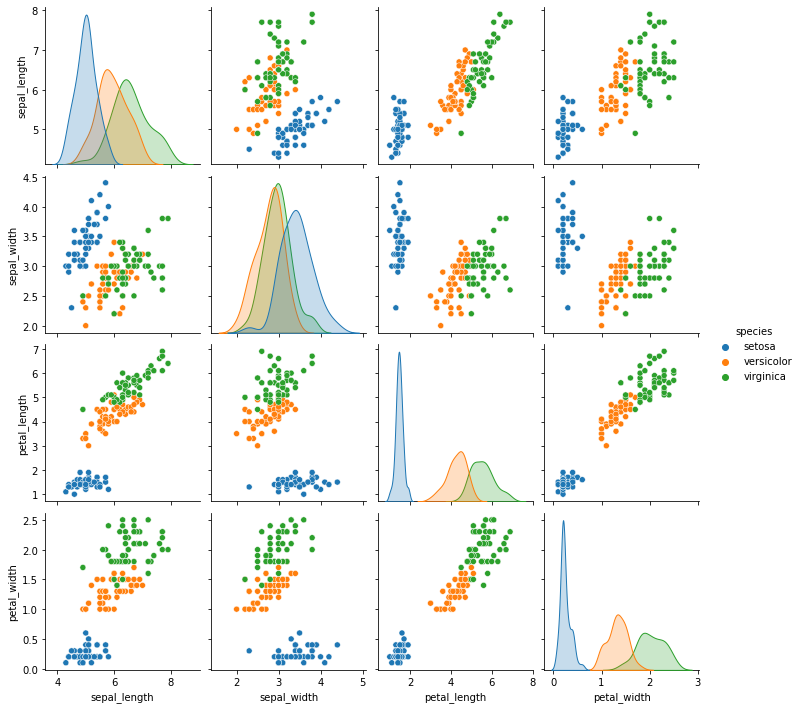

In [7]:
# load iris data
iris_df = sns.load_dataset('iris')   # pandas Data Frame
sns.pairplot(iris_df,hue='species')

# separate out target for train/test split
iris_target = iris_df['species']
iris_features = iris_df.drop(['species'],axis=1)

# split into training/testing datasets
(iris_train_ftrs, iris_test_ftrs,
 iris_train_tgt, iris_test_tgt) = skms.train_test_split(iris_features,
                                                        iris_target,
                                                        test_size=.25)

# create a train DataFrame for convenience
iris_train_df = iris_train_ftrs.copy()
iris_train_df['species'] = iris_train_tgt
display(iris_train_df.head())
#iris_train_df.describe()

### Training a (Gaussian) Naive Bayes classifier by computing means and standard deviations for each category/feature combination
Effectively, 'training' a (Gaussian) Naive Bayes classifier involves computing the mean and standard-deviation values for each feature/category combination. Below we do this by storing the means and standard-deviation values in dictionaries where the key value is a string concatenation of the category and the feature name.  We saw this in Lec06. 

In [8]:
# save in dictionary using concatentation of class name and feature names as keys
means = {}
stds = {}
for c in iris_train_df['species'].unique():
    class_df = iris_train_df[iris_train_df['species'] == c]
    for f in iris_train_ftrs.columns:
        means[c+f] = class_df[f].mean()
        #means[c+f] = class_df[f].sum()/len(class_df[f])
        stds[c+f] = class_df[f].std()
        # without using the std function, you would compute the average squared difference
        # from the mean (but dividing by n-1 instead of n) and take the sqrt
        #stds[c+f] = np.sqrt(np.sum((class_df[f]-means[c+f])**2)/(len(class_df[f])-1))
        print(f'{c}: {f} mean: {means[c+f]:.2f} std: {stds[c+f]:.2f}')
        
# also compute probability of each class based on training data
p_c = {}
for c in iris_train_df['species'].unique():
    p_c[c] = len(iris_train_df[iris_train_df['species'] == c])/len(iris_train_df)
    print(f'p({c}): {p_c[c]:.2f}')

setosa: sepal_length mean: 5.01 std: 0.33
setosa: sepal_width mean: 3.41 std: 0.40
setosa: petal_length mean: 1.48 std: 0.16
setosa: petal_width mean: 0.25 std: 0.10
virginica: sepal_length mean: 6.55 std: 0.68
virginica: sepal_width mean: 2.98 std: 0.37
virginica: petal_length mean: 5.50 std: 0.58
virginica: petal_width mean: 2.06 std: 0.26
versicolor: sepal_length mean: 5.95 std: 0.55
versicolor: sepal_width mean: 2.77 std: 0.29
versicolor: petal_length mean: 4.30 std: 0.49
versicolor: petal_width mean: 1.34 std: 0.19
p(setosa): 0.33
p(virginica): 0.32
p(versicolor): 0.35


### Applying the trained (Gaussian) Naive Bayes classifier to the iris dataset

Once we have computed the mean and standard-deviation values for each category/feature combination as well as the probabilities for each class (effectively 'training' our classifier), we are ready to perform predictions on new data. Effectively, we will apply Bayes' Theorem with the additional assumption of conditional independence between features (and the fact that we can ignore the common denominator) to be able to compute $p(c_i|features) = p(f_1 = f_{1-val}|c_i)p(f_2 = f_{2-val}|c_i) \cdots p(f_n = f_{n-val}|c_i) p(c_i)$ for each category $c_i$. For example, for feature values $pl=5.00$, $pw=1.65$, $sl=6.00$, and $sw=3.00$ for the iris example, we want to compare (and pick the one with the largest likelihood value):

* $p(c=setosa|pl=5.00,pw=1.65,sl=6.00,sw=3.00) = \\
p(pl=5.00|c=setosa)p(pw=1.65|c=setosa)p(sl=6.00|c=setosa)p(sw=3.00|c=setosa)p(setosa)$

* $p(c=versicolor|pl=5.00,pw=1.65,sl=6.00,sw=3.00) = \\
p(pl=5.00|c=versicolor)p(pw=1.65|c=versicolor)p(sl=6.00|c=versicolor)p(sw=3.00|c=versicolor)p(versicolor)$

* $p(c=virginica|pl=5.00,pw=1.65,sl=6.00,sw=3.00) = \\
p(pl=5.00|c=virginica)p(pw=1.65|c=virginica)p(sl=6.00|c=virginica)p(sw=3.00|c=virginica)p(virginica)$

Computing any given $p(f_j=f_{j-val}|c_i)$ for a Gaussian Naive Bayes classifier involves assuming a normal (Gaussian) distribution of the feature values (specified by the mean and standard deviation) and using the equation for the probability density function to determine the relative likelihood value ($\frac{1}{\sigma \sqrt{2\pi}} e^{ \frac{- (f_{val} - \mu)^2}{2 \sigma^2}}$). Below, we visualize the computation of $p(f_j=f_{j-val}|c_i)$ by showing a plot of the probability distrubution function for different cateogories/features.

In [10]:
# Note you probably have to run the cell
# immediately above this cell first, to set the hash values

min_f_val = 0.0
max_f_val = 10.0
@interact
def plot_distribution(c=iris_train_df['species'].unique(), 
                      f=iris_train_ftrs.columns,
                      value=(min_f_val, max_f_val, .1)):
    # if you don't have the jupyter-widgets lab extension installed, you can uncomment
    # one of the following to change the category/species
    # Warming -- leave these commented out before going to next cell
    #c = 'setosa'
    #c = 'virginica'
    #c = 'versicolor'
    # if you don't have the jupyter-widgets lab extension installed, you can uncomment
    # one of the following to change the feature
    #f = 'sepal_length'
    #f = 'sepal_width'
    #f = 'petal_length'
    #f = 'petal_width'

    # loc is mean; scale is standard deviation
    # norm.ppf is Percent Point Function
    x = np.linspace(norm.ppf(0.01,loc=means[c+f],scale=stds[c+f]),norm.ppf(0.99,loc=means[c+f],scale=stds[c+f]), 100)
    plt.plot(x, norm.pdf(x,loc=means[c+f],scale=stds[c+f]));
    
    # help(norm.ppf)
    
    # Note, this is a probability density function
    # Integration  under the curve is 1, but the peak
    # can go above a value of 1
    p_f_given_c = norm.pdf(value,loc=means[c+f],scale=stds[c+f])
    
    # help(norm.pdf)
    
    plt.scatter(value,p_f_given_c,c='r') # the red point
    plt.xlabel(f);
    plt.xlim((min_f_val,max_f_val));
    plt.ylim((0,2.5));
    plt.ylabel('pdf');
    plt.title(f'p({f}={value:0.1f}|c={c}) = {p_f_given_c:.2f}')
    #plt.show()
    return p_f_given_c

interactive(children=(Dropdown(description='c', options=('setosa', 'virginica', 'versicolor'), value='setosa')…

Next we visualize computing $p(c_i|features) = p(f_1 = f_{1-val}|c_i)p(f_2 = f_{2-val}|c_i) \cdots p(f_n = f_{n-val}|c_i) p(c_i)$ for a given category $c_i$ and given feature values. (Repeating this process for all categories and saving the category with the maximum likelihood value would provide the classification, as done in the next cell.)

In [11]:
@interact
def plot_distributions_for_all_features(species=iris_train_df['species'].unique(),
                                        sepal_length = 6.0,
                                        sepal_width = 3.0,
                                        petal_length = 5.0,
                                        petal_width = 1.65):
    # if you don't have the jupyter-widgets lab extension installed, you can uncomment
    # one of the following to change the species
    #species = 'setosa'
    #species = 'virginica'
    #species = 'versicolor'
    plt.subplot(2, 2, 1)
    plt.subplots_adjust(wspace=2.0,hspace=1.0)
    p_sepal_length_given_c = plot_distribution(c=species,           # use the function in cell above
                                               f='sepal_length',
                                               value=sepal_length);
    print(f'species = {species}')
    plt.subplot(2, 2, 2)
    p_sepal_width_given_c = plot_distribution(c=species, 
                                              f='sepal_width',
                                              value=sepal_width);
    plt.subplot(2, 2, 3)
    p_petal_length_given_c = plot_distribution(c=species, 
                                               f='petal_length',
                                               value=petal_length);
    plt.subplot(2, 2, 4)
    p_petal_width_given_c = plot_distribution(c=species,
                                              f='petal_width',
                                              value=petal_width);
    plt.show()
    print(f'p(c={species})={p_c[species]:.2f}\n')
    p_class = p_sepal_length_given_c*p_sepal_width_given_c*p_petal_length_given_c*p_petal_width_given_c*p_c[species]
    print(f'p(c={species}|sl={sepal_length:.2f},sw={sepal_width:.2f},pl={petal_length:.2f},pw={petal_width:.2f})')
    print(f'=p(sl={sepal_length:.2f}|c={species})*p(sw={sepal_width:.2f}|c={species})*p(pl={petal_length:.2f}|c={species})*p(pw={petal_width:.2f}|c={species})*p(c={species})')
    print(f'={p_sepal_length_given_c:.2f}*{p_sepal_width_given_c:.2f}*{p_petal_length_given_c:.2f}*{p_petal_width_given_c:.2f}*{p_c[species]:.2f}')
    print(f'={p_class:0.2f}\n')
    return p_class

interactive(children=(Dropdown(description='species', options=('setosa', 'virginica', 'versicolor'), value='se…

Next, we show applying the above for each category to be able to find the overall classification (by finding the category with maximum likelihood).

In [12]:
@interact
def plot_distributions_for_all_categories(sepal_length = 6.0,
                                          sepal_width = 3.0,
                                          petal_length = 5.0,
                                          petal_width = 1.65):
    print('VERSICOLOR:')
    p_versicolor_given_features = plot_distributions_for_all_features('versicolor',
                                                                      sepal_length,
                                                                      sepal_width,
                                                                      petal_length,
                                                                      petal_width)
    print('VIRGINICA:')
    p_virginica_given_features = plot_distributions_for_all_features('virginica',
                                                                      sepal_length,
                                                                      sepal_width,
                                                                      petal_length,
                                                                      petal_width)
    print('SETOSA:')
    p_setosa_given_features = plot_distributions_for_all_features('setosa',
                                                                  sepal_length,
                                                                  sepal_width,
                                                                  petal_length,
                                                                  petal_width)
    
    # determine classification
    print('CLASSIFICATION: ', end='')
    if (p_versicolor_given_features > p_virginica_given_features and
        p_versicolor_given_features > p_setosa_given_features):
        print('VERSICOLOR')
    elif (p_virginica_given_features > p_versicolor_given_features and
          p_virginica_given_features > p_setosa_given_features):
        print('VIRGINICA')
    else:
        print('SETOSA')

interactive(children=(FloatSlider(value=6.0, description='sepal_length', max=18.0, min=-6.0), FloatSlider(valu…

## Assignment, Part I

### Preliminary set up (loading data, setting up pandas DataFrame, and training the Naive Bayes classifier)

In this part of the assignment, you will use a (Gaussian) Naive Bayes classifier to predict the most likely sport given height, weight, and age data. In the cell below (which you **do NOT** need to modify, but may change the sex/sports if you wish), we use the athlete data from the 2016 Summer Olympics to first create a pandas DataFrame containing height (in inches), weight (in lbs), sport (currently written to be either basketball, gymnastics, and weightlifting), and age (in years) for the athletes. This was also done as part of the lec05 notebook. Next, we split into a training/testing set and create a pandas DataFrame for the training features + targets. We next effectively train a Naive Bayes classifier by computing the mean and standard deviation for each feature/sport combination as well as computing the overall probabilities of each sport.

In [14]:
#-----------------------------------------------------------
# Create pandas DataFrame containing height/weight/age data
#-----------------------------------------------------------
rio_athletes_df_orig = pd.read_csv('rio_athletes.csv')
# sex to analyze (feel free to try either one):
sex_to_analyze = 'female'
#sex_to_analyze = 'male'

# limit to one sex and create dataframe of only dob/height/weight/sport columns 
rio_athletes_df = (rio_athletes_df_orig[rio_athletes_df_orig['sex'] == sex_to_analyze])[['dob','height','weight','sport']]

# remove any rows with missing values
rio_athletes_df.dropna(inplace=True)

# convert height from meters to inches
rio_athletes_df['height'] = rio_athletes_df['height']*39.3701

# convert weight from kg to lbs
rio_athletes_df['weight'] = rio_athletes_df['weight']*2.20462

# convert date strings to actual dates
from datetime import datetime
date_format = "%m/%d/%y"
rio_athletes_df['dob'] = rio_athletes_df['dob'].map(lambda x: datetime.strptime(x,date_format))

# add age column (at start of games: 8/5/2016)
from dateutil.relativedelta import relativedelta
olympics_start = datetime.strptime('08/05/2016','%m/%d/%Y')
rio_athletes_df['age'] = rio_athletes_df['dob'].map(lambda x: relativedelta(olympics_start,x).years)

# drop dob column as we no longer need it
rio_athletes_df = rio_athletes_df.drop(['dob'],axis=1)

# only keep sports of interest (note: you may change these if you would like)
sports_to_analyze = ['basketball', 'gymnastics', 'weightlifting']
rio_athletes_df = rio_athletes_df[rio_athletes_df['sport'].isin(sports_to_analyze)]
#display(rio_athletes_df.head())

#-------------------------------------------------------------
# Split into training/testing data and create separate pandas 
# DataFrame for training data
#-------------------------------------------------------------
# obtain target as the sport column
rio_target = rio_athletes_df['sport']
# obtain features as the DataFrame with the sport column dropped
rio_features = rio_athletes_df.drop(['sport'],axis=1)

# separate into train and test sets (30% of data for testing)
(rio_train_ftrs, rio_test_ftrs,
 rio_train_tgt, rio_test_tgt) = skms.train_test_split(rio_features,
                                                      rio_target,
                                                      test_size=.30)

# create pandas DataFrame with combined training features and targets
rio_train_df = rio_train_ftrs.copy()
rio_train_df['sport'] = rio_train_tgt
display(rio_train_df.head())

#------------------------------------------------------
# compute mean/std of height/weight/age for each sport
#------------------------------------------------------
means = {}
stds = {}
for sport in rio_train_df['sport'].unique():
    sport_df = rio_train_df[rio_train_df['sport'] == sport]
    for f in rio_train_ftrs.columns:
        means[sport+f] = sport_df[f].mean()
        stds[sport+f] = sport_df[f].std()
        print(f'mean {f} in {sport}: {means[sport+f]:.2f} std: {stds[sport+f]:.2f}')
        
# also compute probability of each class based on training data
p_sport = {}
for sport in rio_train_df['sport'].unique():
    p_sport[sport] = len(rio_train_df[rio_train_df['sport'] == sport])/len(rio_train_df)
    print(f'p({sport}): {p_sport[sport]:.2f}')

,height,weight,sport,age
132,66.929170,143.30030,basketball,37
201,75.984293,209.43890,basketball,29
210,57.480346,77.16170,gymnastics,16
212,65.748067,127.86796,gymnastics,20
221,67.322871,101.41252,gymnastics,21


,height,weight,age,sport
7955,73.622087,165.34650,24,basketball
9213,57.086645,101.41252,16,gymnastics
4185,68.503974,262.34978,26,weightlifting
9346,57.086645,74.95708,16,gymnastics
7347,76.771695,182.98346,24,basketball


mean height in basketball: 71.90 std: 3.63
mean weight in basketball: 164.43 std: 22.26
mean age in basketball: 27.91 std: 4.39
mean height in gymnastics: 63.48 std: 3.59
mean weight in gymnastics: 109.42 std: 12.03
mean age in gymnastics: 20.60 std: 3.97
mean height in weightlifting: 63.03 std: 2.65
mean weight in weightlifting: 144.65 std: 35.38
mean age in weightlifting: 24.37 std: 4.26
p(basketball): 0.33
p(gymnastics): 0.46
p(weightlifting): 0.21


### Your task: predicting most likely sport given height, weight, and age feature values
Your task for this part of the assignment will be to use the ideas behind a (Gaussian) Naive Bayes classifier to compute the most likely sport given the feature values defined below (you may change the feature values if you wish). For this step, you may NOT call any sklearn functions and instead will use the means/standard deviations above (as well as the simplified form of Bayes' theorem we use for Naive Bayes classification). 

To do this, recall that you will need to use the following equation to compute the relative likelihood of each sport. 

$p(sport_i|height=height_{val},weight=weight_{val},age=age_{val}) = p(height=height_{val}|sport_i)p(weight=weight_{val}|sport_i)p(age=age_{val}|sport_i)p(sport_i)$

Note that $sport_i$ is one of the three sports defined above (by default, gymnastics, basketball, or weightlifting unless you have changed the code to use a different set of sports). Thus, you will need to compute:
* $p(gymnastics|height=height_{val},weight=weight_{val},age=age_{val}) 
= p(height=height_{val}|gymnastics)p(weight=weight_{val}|gymnastics)p(age=age_{val}|gymnastics)p(gymnastics)$
* $p(basketball|height=height_{val},weight=weight_{val},age=age_{val}) 
= p(height=height_{val}|basketball)p(weight=weight_{val}|basketball)p(age=age_{val}|basketball)p(basketball)$
* $p(weightlifting|height=height_{val},weight=weight_{val},age=age_{val}) 
= p(height=height_{val}|weightlifting)p(weight=weight_{val}|weightlifting)p(age=age_{val}|weightlifting)p(weightlifting)$

To estimate the probabilty (technically, relative likelihood) of each feature value given the sport (e.g., $p(height=height_{val}|sport_i)$), you will want to use the norm.pdf function which returns the relative likelihood value given: a feature value, mean of that feature in the training set given the class, and standard deviation of that feature in the training set given the class. For example, $p(height=60|gymnastics)$ could be computed from norm.pdf(60,loc=means['gymnasticsheight'],scale=stds['gymnasticsheight']) using the dictionary of means and standard deviations computed above **(the key for use with the dictionaries is the concatenation of the sport and the feature value).** More specifically, if the feature value for height was defined as height_val, you could write a line of python code similar to the following:

**p_height_given_gymnastics = norm.pdf(height_val,loc=means['gymnasticsheight'],scale=stds['gymnasticsheight'])**

$p(sport_i)$ was defined earlier by the dictionary p_sport. For example, to compute the probability p(gymnastics), you would write p_sport['gymnastics'] in your code. 

Once you compute the three relative likelihood values (one for each sport), the classified sport will be defined as the one with the highest relative likelihood. 

Since this problem is designed to mimic what you would need to do 'by hand' (with the exception that you will be letting python compute the pdf values for you and the fact that the mean and standard deviation values have already been computed for each feature/sport combination for you), it is perfectly fine to write out each case separately (e.g., not use any loops). However, you may use loops if you would like. 

Also, you may also just display the three resulting likelihood values and put a comment in your code to indicate which one is largest one rather than programatically determining the largest.

In [28]:
# define feature values (you may change these if you wish)
height_val = 60
weight_val = 150
age_val = 20

# compute relative likelihood for each sport and either display all 
# likelihood values (and let the user determine which one is largest)
# and/or programatically display the sport with the highest likelihood 
# YOUR CODE HERE
#raise NotImplementedError()


p_height_given_gymnastics = norm.pdf(height_val, loc=means['gymnasticsheight'], scale=stds['gymnasticsheight'])
p_weight_given_gymnastics = norm.pdf(weight_val, loc=means['gymnasticsweight'], scale=stds['gymnasticsweight'])
p_age_given_gymnastics = norm.pdf(age_val, loc=means['gymnasticsage'], scale=stds['gymnasticsage'])

p_height_given_basketball = norm.pdf(height_val, loc=means['basketballheight'], scale=stds['basketballheight'])
p_weight_given_basketball = norm.pdf(weight_val, loc=means['basketballweight'], scale=stds['basketballweight'])
p_age_given_basketball = norm.pdf(age_val, loc=means['basketballage'], scale=stds['basketballage'])

p_height_given_weightlifting = norm.pdf(height_val, loc=means['weightliftingheight'], scale=stds['weightliftingheight'])
p_weight_given_weightlifting = norm.pdf(weight_val, loc=means['weightliftingweight'], scale=stds['weightliftingweight'])
p_age_given_weightlifting = norm.pdf(age_val, loc=means['weightliftingage'], scale=stds['weightliftingage'])

p_gymnastics = p_height_given_gymnastics * p_weight_given_gymnastics * p_age_given_gymnastics * p_sport['gymnastics']
p_basketball = p_height_given_basketball * p_weight_given_basketball * p_age_given_basketball * p_sport['basketball']
p_weightlifting = p_height_given_weightlifting * p_weight_given_weightlifting * p_age_given_weightlifting * p_sport['weightlifting']
print('Gymnastics probability', p_gymnastics)
print('Basketball probability', p_basketball)
print('Weightlifting probability', p_weightlifting)

x = max(p_gymnastics, p_basketball, p_weightlifting)

if x == p_gymnastics:
    print('gymnastics')
elif x == p_basketball:
    print('basketball')
else:
    print('weightlifting')


Gymnastics probability 3.5462291425673015e-07
Basketball probability 4.398644385395629e-08
Weightlifting probability 1.014790637222768e-05
weightlifting


## Example of k-NN and Naive Bayes classification on a dataset with sample points that overlap substantially
Below we create an example dataset with two features and two categories where the sample points overlap substantially. In this case, you wouldn't expect any classification strategy to work well.

,f1,f2,category
0,3.557788,5.354180,class_1
1,3.600701,3.710763,class_2
2,6.168982,3.404821,class_2
3,4.310880,5.951999,class_2
4,4.624715,5.130570,class_2


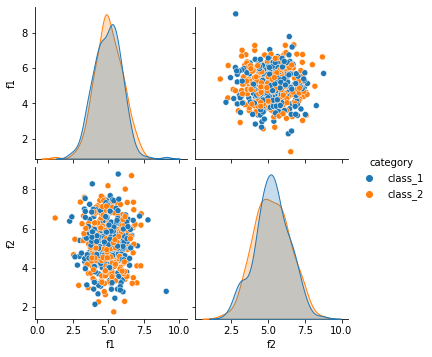

In [19]:
mean_f1 = 5.0
std_f1 = 1.0
mean_f2 = 5.2
std_f2 = 1.2
overlap_df = pd.DataFrame({'f1': np.random.normal(mean_f1,std_f1,500),
                           'f2': np.random.normal(mean_f2,std_f2,500),
                           'category':  np.random.randint(0,2,500)})
class_labels = ['class_1', 'class_2']
overlap_df['category'] = overlap_df['category'].map(lambda x: class_labels[x])
display(overlap_df.head())
sns.pairplot(overlap_df,hue='category');

Below we split the data into training/testing sets and train both a k-NN classifier (with k=1) and a Naive Bayes classifier. 

In [20]:
# separate features from target
target = overlap_df['category']
features = overlap_df.drop(['category'],axis=1)

# separate into train and test sets (30% of data for testing)
(train_ftrs, test_ftrs,
 train_tgt, test_tgt) = skms.train_test_split(features,
                                              target,
                                              test_size=.30)

# set up two classifier models and train each of them:
# 1. k-NN with k=1
model_kNN = neighbors.KNeighborsClassifier(n_neighbors=1)
fit_kNN = model_kNN.fit(train_ftrs, train_tgt)
# 2. Naive Bayes 
model_NB = naive_bayes.GaussianNB()
fit_NB = model_NB.fit(train_ftrs, train_tgt)

Next, we define a helper function (based on the same code we used in lec05 to visualize the decision boundaries for a k-NN classifier) to help us visualize decision boundaries for two features of a trained classifier.

In [21]:
def visualize_decision_grid(fit, ftrs_to_plot_df, f1, f2, tgt_to_plot, show_scatter = True):
    """
    Plots color-coded grid of predictions using trained sklearn fit model.
    Also plots a scatter-plot of the indicated features with color-coded targets. 
    As currently written, it is assumed that there are no more than 3 target 
    categories (using more would just require defining more colors to be used in the plots)
    This is based on the code written as part of the lec04 examples, but without
    also including separate train/test scatter points. 
    
    Inputs:
    fit: trained model (i.e., result of calling sklearn's fit function on model)
    ftrs_to_plot_df: dataframe containing features (2D numpy arrarys NOT allowed)
    f1: column name of feature 1 to plot
    f2: column name of feature 2 to plot
    tgt_to_plot: known target values for features to plot (assumed to be category names)
    showScatter: whether to show the scatter points
    """   
    #------------------------------------------
    # get meshgrid of f1 and f2 values to plot
    # (use a range slighter larger than the
    # actual range of the data)
    #------------------------------------------
    # start with actual min/max of f1 and f2
    min_f1_val = ftrs_to_plot_df[f1].min()
    max_f1_val = ftrs_to_plot_df[f1].max()
    min_f2_val = ftrs_to_plot_df[f2].min()
    max_f2_val = ftrs_to_plot_df[f2].max()
    # increase range slightly
    min_f1_val = min_f1_val - (max_f1_val - min_f1_val)/10
    max_f1_val = max_f1_val + (max_f1_val - min_f1_val)/10
    min_f2_val = min_f2_val - (max_f2_val - min_f2_val)/10
    max_f2_val = max_f2_val + (max_f2_val - min_f2_val)/10
    # use linspace to get array of 100 points for 
    # f1 and f2 and in expanded range
    f1_vals_to_plot = np.linspace(min_f1_val, max_f1_val, 100)
    f2_vals_to_plot = np.linspace(min_f2_val, max_f2_val, 100)
    # get meshgrid of f1 and f2 vlaues
    f1_grid, f2_grid = np.meshgrid(f1_vals_to_plot,f2_vals_to_plot)

    #------------------------------------------------
    # get prediction for every point on feature grid
    #------------------------------------------------
    # Note: need to use ravel to flatten arrays when passing
    # to sklearn's predict function
    # create dataframe with one column for flattened f1 values and another
    # column for flattened f2 values
    f1_f2_grids_flat_df = pd.DataFrame({f1: f1_grid.ravel(), f2: f2_grid.ravel()})
    # apply predictions on dataframe
    predictions_grid_flat= fit.predict(f1_f2_grids_flat_df)
    # convert to numerical values
    tgt_names = tgt_to_plot.unique()
    predictions_grid_flat = np.array([np.where(tgt_names == x)[0] for x in predictions_grid_flat])
    # reshape back to 2D
    predictions_grid = predictions_grid_flat.reshape(f1_grid.shape)

    #--------------------------
    # plot grid of predictions
    #--------------------------
    potential_colors = ['cornflowerblue', 'orange', 'lightgreen']
    num_cat = len(tgt_names)
    colors = potential_colors[0:num_cat]
    cmap_light = ListedColormap(colors)
    plt.pcolormesh(f1_grid,f2_grid,predictions_grid,cmap=cmap_light);

    #-----------------------------------
    # also plot training points
    #-----------------------------------
    if (show_scatter):
        # plot the training points (one category at a time)
        scatter_colors = ['darkblue', 'darkorange', 'darkgreen']
        for i,cat in enumerate(tgt_names):
            category_df = ftrs_to_plot_df[tgt_to_plot == cat]
            plt.scatter(category_df[f1],category_df[f2],
                        c=scatter_colors[i],
                        label=cat,
                        edgecolors='k')
        plt.legend()
        
    plt.xlabel(f1);
    plt.ylabel(f2);

We next visualize the decision boundaries for our trained k-NN classifier (with k=1). Before running the code, try to guess what the plot might look like (e.g., would you expect many separate decision regions or just a few).

C:\Users\Natha\AppData\Local\Temp/ipykernel_51036/2651226460.py:63: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(f1_grid,f2_grid,predictions_grid,cmap=cmap_light);


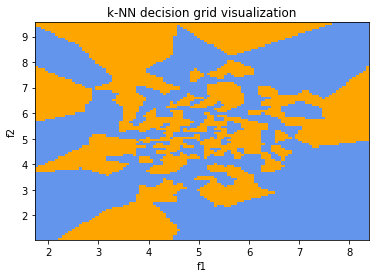

C:\Users\Natha\AppData\Local\Temp/ipykernel_51036/2651226460.py:63: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(f1_grid,f2_grid,predictions_grid,cmap=cmap_light);


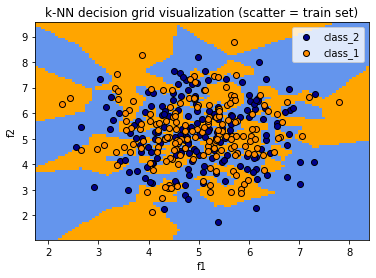

In [22]:
# visualize decision boundaries for k-NN (with k=1)
visualize_decision_grid(fit_kNN, train_ftrs, 'f1', 'f2', train_tgt, show_scatter=False)
plt.title('k-NN decision grid visualization');
plt.show();
visualize_decision_grid(fit_kNN, train_ftrs, 'f1', 'f2', train_tgt)
plt.title('k-NN decision grid visualization (scatter = train set)');
plt.show();

We next visualize the decision boundaries for our trained Naive Bayes classifier. Before running the code, try to guess what the plot might look like (would you expect many separate decision regions or just a few).

C:\Users\Natha\AppData\Local\Temp/ipykernel_51036/2651226460.py:63: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(f1_grid,f2_grid,predictions_grid,cmap=cmap_light);


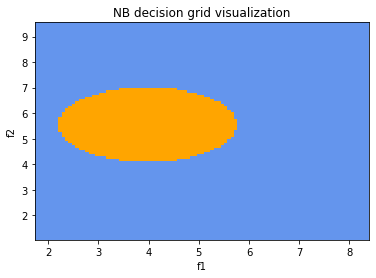

C:\Users\Natha\AppData\Local\Temp/ipykernel_51036/2651226460.py:63: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(f1_grid,f2_grid,predictions_grid,cmap=cmap_light);


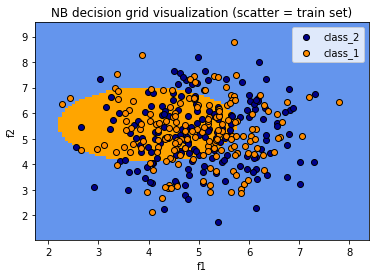

In [25]:
# visualize decision boundaries for NB
visualize_decision_grid(fit_NB, train_ftrs, 'f1', 'f2', train_tgt, show_scatter=False)
plt.title('NB decision grid visualization');
plt.show();
visualize_decision_grid(fit_NB, train_ftrs, 'f1', 'f2', train_tgt)
plt.title('NB decision grid visualization (scatter = train set)');
plt.show();

## Assignment, Part II
In this part of the assignment, you will first evaluate both classifiers on the TEST set. More specifically, as you have done multiple times in the past using sklearn's functionality, you should apply the **predict** function on each trained model (fit_kNN and fit_NB) to obtain the target predictions from the test set features **(test_ftrs)**. You should then compute the accuracy in each case using the metrics.accuracy_score function and display the results. Since the samples in the dataset overlap so much, you should expect very poor results (e.g., around 50%, which is what you would also get by just using a coin to guess each result).  

In [36]:
# apply each trained model to test data and evaluate using accuracy metric
# YOUR CODE HERE
#raise NotImplementedError()


predictionkNN = fit_kNN.predict(test_ftrs)

predictionNB = fit_NB.predict(test_ftrs)

score1 = metrics.accuracy_score(test_tgt, predictionkNN)
print(f'kNN Model accuracy: {score1:0.2f}')
score2 = metrics.accuracy_score(test_tgt, predictionNB)
print(f'NB Model accuracy: {score2:0.2f}')

kNN Model accuracy: 0.54
NB Model accuracy: 0.53


Next, think about what you think the approximate accuracy would be if you would apply your trained classifiers to the training data itself. After you have made your guess (you don't need to write it down), in the cell below, check your intuition by evaluating both classifiers on the data from the TRAIN set. More specifically, in this case, you will apply the **predict** function on each trained model (fit_kNN and fitNB) to obtain target predictions from the TRAIN set features **(train_ftrs)**. You will then compute the accuracy (making sure to compare your predictions to train_tgt rather than test_tgt) in each case and display it. 

Things to think about (you do not need to write this down): Were your results what you expected? Based on how each classifier works, why do you think you obtained the results you did?

Note: the k-NN case provides a good example of why it can be very important to evaluate the data on a separate test set. 

In [37]:
# apply each trained model to train data and evaluate using accuracy metric
# YOUR CODE HERE
#raise NotImplementedError()

predictionkNN = fit_kNN.predict(train_ftrs)

predictionNB = fit_NB.predict(train_ftrs)

score1 = metrics.accuracy_score(train_tgt, predictionkNN)
print(f'kNN Model accuracy: {score1:0.2f}')
score2 = metrics.accuracy_score(train_tgt, predictionNB)
print(f'NB Model accuracy: {score2:0.2f}')

kNN Model accuracy: 1.00
NB Model accuracy: 0.51


FYI: Below is code to be able to visualize the decision boundaries for the trained k-NN classifier and Naive Bayes classifier with the scatter points being the test points rather than the training points. (You do not need to modify this cells in any way: they are just there to help you further visualize the results obtained above.)

C:\Users\Natha\AppData\Local\Temp/ipykernel_51036/2651226460.py:63: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(f1_grid,f2_grid,predictions_grid,cmap=cmap_light);


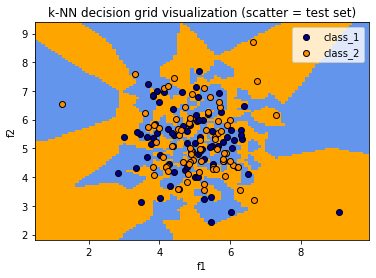

C:\Users\Natha\AppData\Local\Temp/ipykernel_51036/2651226460.py:63: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(f1_grid,f2_grid,predictions_grid,cmap=cmap_light);


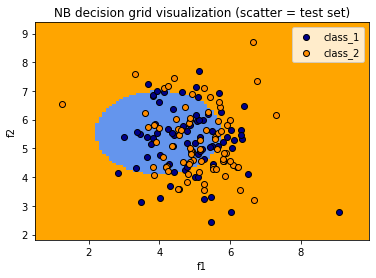

In [38]:
# visualize decision boundaries for k-NN (with k=1) with testing scatter points
visualize_decision_grid(fit_kNN, test_ftrs, 'f1', 'f2', test_tgt)
plt.title('k-NN decision grid visualization (scatter = test set)');
plt.show()
# visualize decision boundaries for NB with testing scatter points
visualize_decision_grid(fit_NB, test_ftrs, 'f1', 'f2', test_tgt)
plt.title('NB decision grid visualization (scatter = test set)');